In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Binary Classification to classify breast cancer cells, using transfer learning. 
# Author : [Harirai](https://github.com/Harirai)




Date : 26/05/2020  
We will try different pre-trained models and use transfer learning to predict the class of cells.


In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os 
import tensorflow as tf
print(tf.__version__)

# Limit output length/
from notebook.services.config import ConfigManager
cm = ConfigManager().update('notebook', {'limit_output': 1000})


2.2.0


Set our input pipeline. (If you have dataset on drive, mount drive from left sidebar or run the cell below)




In [49]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# To input our dataset easily, we will use `ImageDataGenerator` which requires directory tree as shown :
![dir tree](https://miro.medium.com/max/1682/1*HpvpA9pBJXKxaPCl5tKnLg.jpeg)



## Now The fun begins!!  
Let's see some of the images in the dataset.

In [50]:
base_dir = "/content/drive/My Drive/Dataset"
train_dir = "/content/drive/My Drive/Dataset/train"
test_dir  = "/content/drive/My Drive/Dataset/test"
train_b = "/content/drive/My Drive/Dataset/train/Benign"
train_m = "/content/drive/My Drive/Dataset/train/Malignant"
test_b = "/content/drive/My Drive/Dataset/test/Benign"
test_m = "/content/drive/My Drive/Dataset/test/Malignant"

In [51]:
# List all the files in the directory
train_b_fnames = os.listdir(train_b)
train_m_fnames = os.listdir(train_m)

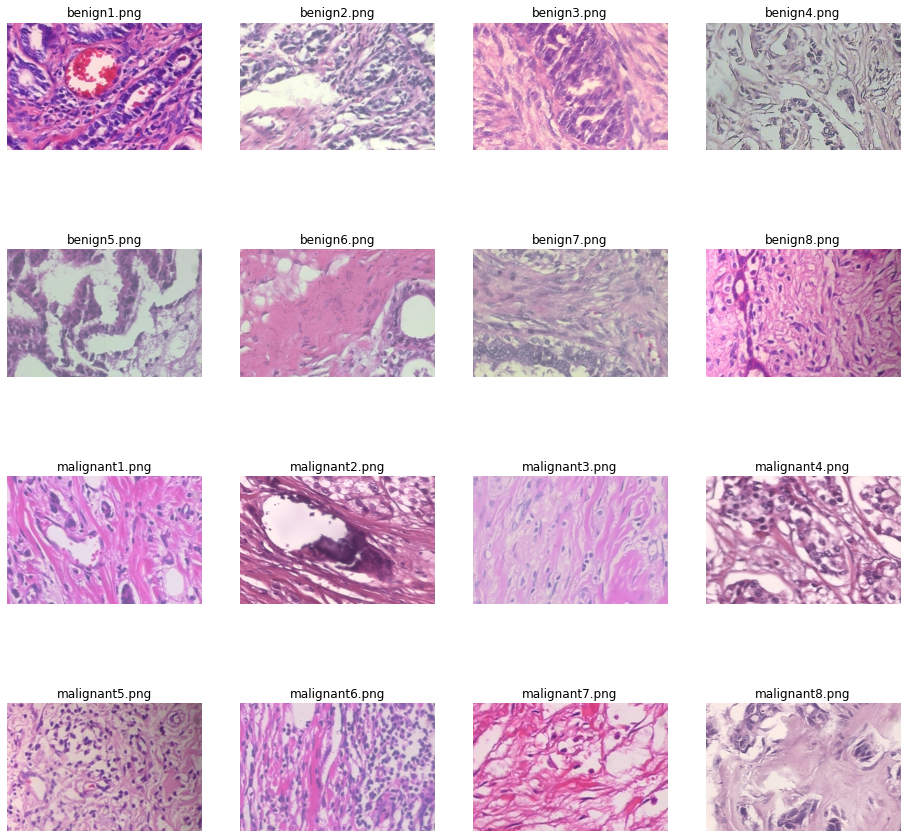

In [52]:
# Let's see some of our images
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

pic_index = 0 # Index for iterating over images

# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)

# 8 images from each class
pic_index+=8

# Benign Images
next_b_pix = [os.path.join(train_b, fname) 
                for fname in train_b_fnames[ pic_index-8:pic_index] 
               ]
# Malignant Images
next_m_pix = [os.path.join(train_m, fname) 
                for fname in train_m_fnames[ pic_index-8:pic_index]
               ]

for i, img_path in enumerate(next_b_pix+next_m_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.title(img_path.split("/")[-1])
  plt.imshow(img)

plt.show()



In [53]:
# Function to plot acc and loss vs epochs
def plot_graphs(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  plt.figure(figsize=(8, 8))
  plt.subplot(2, 1, 1)
  plt.plot(acc, label='Training Accuracy')
  plt.plot(val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.ylabel('Accuracy')
  plt.ylim([min(plt.ylim()),1])
  plt.title('Training and Validation Accuracy')

  plt.subplot(2, 1, 2)
  plt.plot(loss, label='Training Loss')
  plt.plot(val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.ylabel('Cross Entropy')
  plt.ylim([0,1.0])
  plt.title('Training and Validation Loss')
  plt.xlabel('epoch')
  plt.show()


In [64]:
# We have very few images so we can use Data Augmentation to imporve performance

IMAGE_SIZE = 224 
BATCH_SIZE = 16  # We have very few examples in our dataset, So I thought of using Batch size of 1, you may experiment with it!

from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   width_shift_range = 0.05, # image can be shifted 5 % to left or right
                                   height_shift_range = 0.05, # similar
                                   horizontal_flip = True, 
                                   #vertical_flip = True,
                                   )

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator( rescale = 1.0/255. )

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE, 
    class_mode='binary',
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE, 
    class_mode='binary'
)




Found 1354 images belonging to 2 classes.
Found 659 images belonging to 2 classes.


In [55]:
print(train_generator.class_indices)


{'Benign': 0, 'Malignant': 1}


In [56]:
# Load MobileNetV24

from tensorflow.keras.applications import MobileNetV2
IMG_SHAPE = (IMAGE_SIZE , IMAGE_SIZE , 3)

base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                              include_top=False, 
                                              weights='imagenet')
# VGG
from tensorflow.keras.applications import VGG19

vgg_model = VGG19(
    input_shape=IMG_SHAPE,
    include_top=False,
    weights='imagenet',
)


In [57]:
base_model.trainable = False

In [58]:
base_model.summary()


Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
_______________________________________________________________________________

In [59]:
vgg_model.trainable=False
vgg_model.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [60]:
def my_model(base_model):
  return tf.keras.Sequential([
                              base_model,
                              tf.keras.layers.GlobalAveragePooling2D(),
                              tf.keras.layers.Dropout(0.4),
                              tf.keras.layers.BatchNormalization(),
                              tf.keras.layers.Dense(256, activation='relu'),
                              tf.keras.layers.Dense(64, activation='relu'),
                              tf.keras.layers.Dense(1, activation='sigmoid')
  ])

In [61]:
model = my_model(base_model)
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1280)              0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 1280)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 1280)              5120      
_________________________________________________________________
dense_2 (Dense)              (None, 256)               327936    
_________________________________________________________________
dense_3 (Dense)              (None, 64)                16448     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                

In [62]:
my_vgg = my_model(vgg_model)
my_vgg.summary()


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Model)                (None, 7, 7, 512)         20024384  
_________________________________________________________________
global_average_pooling2d_3 ( (None, 512)               0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
dense_5 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_6 (Dense)              (None, 64)                16448     
_________________________________________________________________
dense_7 (Dense)              (None, 1)                

In [65]:
# Transfer Learning on MobileNet
from tensorflow import keras
model.compile(optimizer=tf.keras.optimizers.Adam(lr=5e-4), 
              loss='binary_crossentropy', 
              metrics=['accuracy', 
              keras.metrics.TruePositives(name='tp'),
              keras.metrics.FalsePositives(name='fp'),
              keras.metrics.TrueNegatives(name='tn'),
              keras.metrics.FalseNegatives(name='fn'),
              # keras.metrics.Precision(name='precision'),
              # keras.metrics.Recall(name='recall'),
              # keras.metrics.AUC(name='auc'),
])

In [66]:
epochs = 10
history  = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=epochs,
)

Epoch 1/10
85/85 [==============================] - 827s 10s/step - loss: 0.5351 - accuracy: 0.7555 - tp: 818.0000 - fp: 225.0000 - tn: 205.0000 - fn: 106.0000 - val_loss: 0.5011 - val_accuracy: 0.7739 - val_tp: 365.0000 - val_fp: 48.0000 - val_tn: 145.0000 - val_fn: 101.0000
Epoch 2/10
85/85 [==============================] - 49s 578ms/step - loss: 0.4779 - accuracy: 0.7747 - tp: 823.0000 - fp: 204.0000 - tn: 226.0000 - fn: 101.0000 - val_loss: 0.4839 - val_accuracy: 0.7602 - val_tp: 396.0000 - val_fp: 88.0000 - val_tn: 105.0000 - val_fn: 70.0000
Epoch 3/10
85/85 [==============================] - 49s 581ms/step - loss: 0.4230 - accuracy: 0.8102 - tp: 840.0000 - fp: 173.0000 - tn: 257.0000 - fn: 84.0000 - val_loss: 0.4614 - val_accuracy: 0.7830 - val_tp: 425.0000 - val_fp: 102.0000 - val_tn: 91.0000 - val_fn: 41.0000
Epoch 4/10
85/85 [==============================] - 51s 598ms/step - loss: 0.3889 - accuracy: 0.8272 - tp: 842.0000 - fp: 152.0000 - tn: 278.0000 - fn: 82.0000 - val_loss

In [69]:
# Transfer Learning on VGG
from tensorflow import keras
my_vgg.compile(optimizer=tf.keras.optimizers.Adam(lr=5e-4), 
              loss='binary_crossentropy', 
              metrics=['accuracy', 
              keras.metrics.TruePositives(name='tp'),
              keras.metrics.FalsePositives(name='fp'),
              keras.metrics.TrueNegatives(name='tn'),
              keras.metrics.FalseNegatives(name='fn'),
              # keras.metrics.Precision(name='precision'),
              # keras.metrics.Recall(name='recall'),
              # keras.metrics.AUC(name='auc'),
])

epochs = 10
vgg_history  = my_vgg.fit(
    train_generator,
    validation_data=test_generator,
    epochs=epochs,
)


Epoch 1/10
85/85 [==============================] - 57s 671ms/step - loss: 0.5737 - accuracy: 0.7112 - tp: 866.0000 - fp: 333.0000 - tn: 97.0000 - fn: 58.0000 - val_loss: 0.6109 - val_accuracy: 0.7891 - val_tp: 408.0000 - val_fp: 81.0000 - val_tn: 112.0000 - val_fn: 58.0000
Epoch 2/10
85/85 [==============================] - 55s 650ms/step - loss: 0.5267 - accuracy: 0.7422 - tp: 817.0000 - fp: 242.0000 - tn: 188.0000 - fn: 107.0000 - val_loss: 0.5521 - val_accuracy: 0.7860 - val_tp: 433.0000 - val_fp: 108.0000 - val_tn: 85.0000 - val_fn: 33.0000
Epoch 3/10
85/85 [==============================] - 55s 647ms/step - loss: 0.5045 - accuracy: 0.7710 - tp: 829.0000 - fp: 215.0000 - tn: 215.0000 - fn: 95.0000 - val_loss: 0.4997 - val_accuracy: 0.8027 - val_tp: 433.0000 - val_fp: 97.0000 - val_tn: 96.0000 - val_fn: 33.0000
Epoch 4/10
85/85 [==============================] - 56s 654ms/step - loss: 0.4864 - accuracy: 0.7622 - tp: 817.0000 - fp: 215.0000 - tn: 215.0000 - fn: 107.0000 - val_loss: 

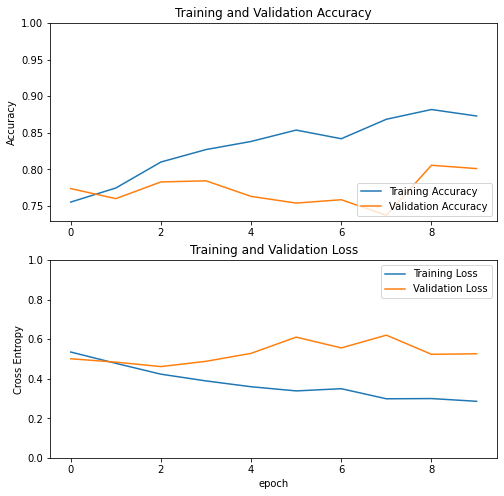

In [67]:
plot_graphs(history)

In [68]:
# Now we can convert our model into Tflite file

saved_model_dir = 'save/fine_tuning'
tf.saved_model.save(model, saved_model_dir)  # Save model at specified path

converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
tflite_model = converter.convert()

with open('model.tflite', 'wb') as f:
  f.write(tflite_model)


# Save labels with corresponding to index
print (train_generator.class_indices)

labels = '\n'.join(sorted(train_generator.class_indices.keys()))

with open('labels.txt', 'w') as f:
  f.write(labels)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: save/fine_tuning/assets
{'Benign': 0, 'Malignant': 1}


In [ ]:
# Download the files from left sidebar!!